In [30]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from skimage import io
import time
import psutil
from keras.callbacks import EarlyStopping

Class 'AnnualCrop' has 3000 images.
Class 'Forest' has 3000 images.
Class 'HerbaceousVegetation' has 3000 images.
Class 'Highway' has 2500 images.
Class 'Industrial' has 2500 images.
Class 'Pasture' has 2000 images.
Class 'PermanentCrop' has 2500 images.
Class 'Residential' has 3000 images.
Class 'River' has 2500 images.
Class 'SeaLake' has 3000 images.
Class 'test' has 0 images.
Class 'train' has 0 images.
Class 'validation' has 0 images.


C:\Users\Brenon\AppData\Local\Temp\ipykernel_8448\152642512.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=data, palette='deep')


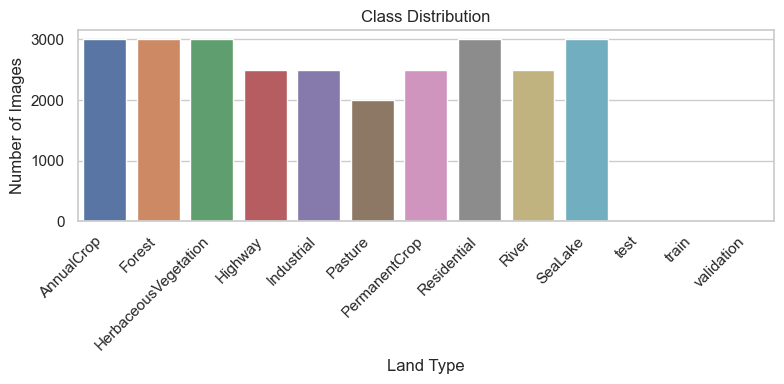

In [22]:
base_dir = r"C:\Users\Brenon\Desktop\archive\EuroSAT"

# Get class labels
class_labels = [label for label in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, label))]

# Create empty frame
class_counts = {}

# Loop through each class and count the number of images
for label in class_labels:
    class_path = os.path.join(base_dir, label)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[label] = num_images

for label, count in class_counts.items():
    print(f"Class '{label}' has {count} images.")

data = pd.DataFrame(class_counts.items(), columns=['Class', 'Count'])

# Plotting the bar chart using Seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x='Class', y='Count', data=data, palette='deep')
plt.xlabel('Land Type')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

Image dimensions (height x width x channels): (64, 64, 3)


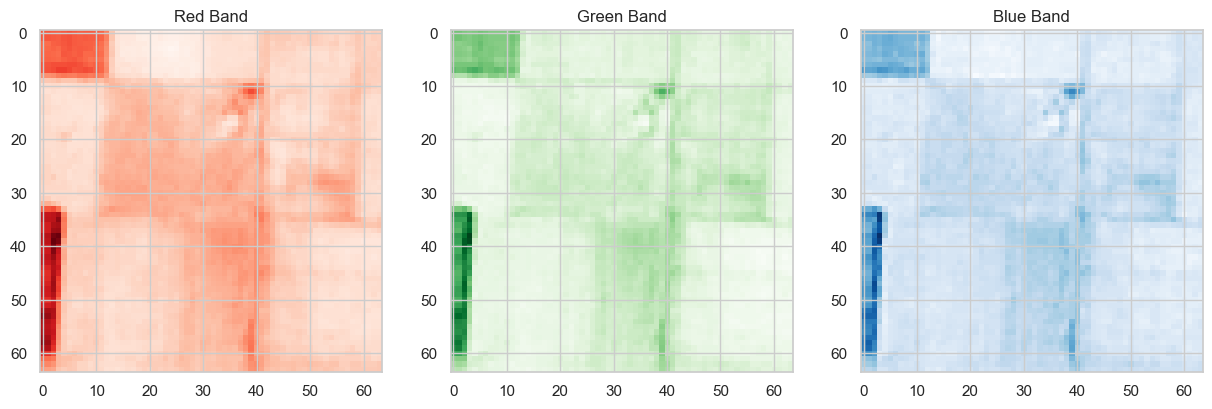

In [23]:
image = io.imread(r"C:\Users\Brenon\Desktop\archive\EuroSAT\AnnualCrop\AnnualCrop_1.jpg")


# Display the individual color bands
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image[:, :, 0], cmap='Reds')
axs[0].set_title('Red Band')
axs[1].imshow(image[:, :, 1], cmap='Greens')
axs[1].set_title('Green Band')
axs[2].imshow(image[:, :, 2], cmap='Blues')
axs[2].set_title('Blue Band')

print("Image dimensions (height x width x channels):", image.shape)

Displaying random samples from each class:


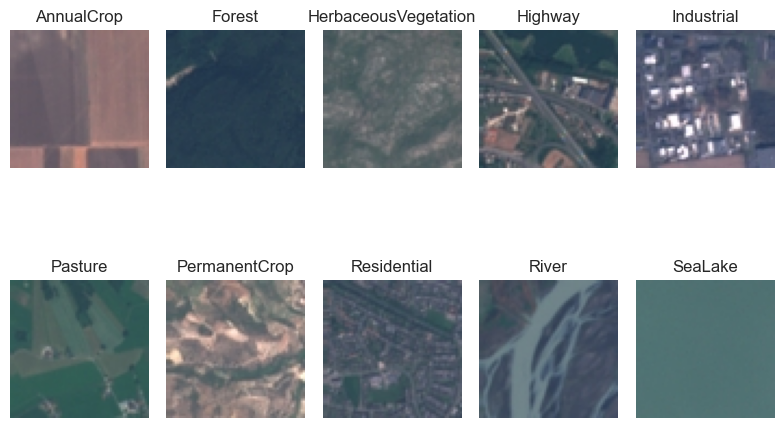

In [24]:
num_images_to_display = 1  # Number of random images to display per class
overall_images_to_display = []

# Loop through folders/class
for label in class_labels:
    class_path = os.path.join(base_dir, label)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[label] = num_images

    # Use random.sample function on each class
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    images_to_display = random.sample(image_files, min(num_images_to_display, len(image_files)))
    overall_images_to_display.extend([(os.path.join(class_path, image_file), label) for image_file in images_to_display])

# Display the images
print("Displaying random samples from each class:")
num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))  # Adjust the figure size as needed
for i, (image_path, label) in enumerate(overall_images_to_display):
    row = i // num_cols
    col = i % num_cols
    image = Image.open(image_path)
    
    # Resize the image
    width, height = image.size
    new_width = 64  # Choose your desired width
    new_height = 64  # Choose your desired height
    image = image.resize((new_width, new_height))
    
    # Display the resized image
    axes[row, col].imshow(image)
    axes[row, col].set_title(label)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [25]:
# Load CSV files
train_csv = pd.read_csv(r"C:\Users\Brenon\Desktop\archive\EuroSAT\train.csv")
test_csv = pd.read_csv(r"C:\Users\Brenon\Desktop\archive\EuroSAT\test.csv")
validation_csv = pd.read_csv(r"C:\Users\Brenon\Desktop\archive\EuroSAT\validation.csv")

# Define generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=base_dir,
    x_col="Filename",  # Adjust to match the column name containing filenames
    y_col="ClassName",  # Adjust to match the column name containing class names
    target_size=(64, 64),
    batch_size=8,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=base_dir,
    x_col="Filename",  # Adjust to match the column name containing filenames
    y_col="ClassName",  # Adjust to match the column name containing class names
    target_size=(64, 64),
    batch_size=1,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_csv,
    directory=base_dir,
    x_col="Filename",  # Adjust to match the column name containing filenames
    y_col="ClassName",  # Adjust to match the column name containing class names
    target_size=(64, 64),
    batch_size=8,
    class_mode='categorical')

Found 18900 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.


In [26]:
def get_cpu_usage():
    return psutil.cpu_percent

from keras.layers import Input

# Define the CNN model architecture
model = Sequential()
model.add(Input(shape=(64, 64, 3)))  # Use Input() layer as the first layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Early stopping  will halt the modeling after 3 consecutive Epochs of increasing validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Time the model - begin
start_time_CNN = time.time()

# get CPU usage start
cpu_usage_start_CNN = psutil.cpu_percent(interval=None)


# Train the model using the generator with early stopping
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=None,
    callbacks=[early_stopping])

# old validation_steps argument used to be "validation_steps=len(validation_generator)"
## the validation steps/batchsize/epochs was incorrect, the model was running out od training data so this argument required adjustment

# get CPU usage end
cpu_usage_end_CNN = psutil.cpu_percent(interval=None)

# Time the model - end
end_time_CNN = time.time()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

cpu_usage_final_CNN = cpu_usage_end_CNN-cpu_usage_start_CNN
model_timer_final_CNN = end_time_CNN-start_time_CNN

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("CPU usage:", cpu_usage_final_CNN, "%")
print("CNN model elapsed training time:", model_timer_final_CNN, "seconds")

Epoch 1/20
  21/2363 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.0570 - loss: 2.3197   

c:\Users\Brenon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2363/2363 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.3862 - loss: 1.5696 - val_accuracy: 0.6565 - val_loss: 0.9604
Epoch 2/20
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7019 - loss: 0.8323 - val_accuracy: 0.7780 - val_loss: 0.6159
Epoch 3/20
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7570 - loss: 0.6640 - val_accuracy: 0.7107 - val_loss: 0.7917
Epoch 4/20
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7979 - loss: 0.5571 - val_accuracy: 0.8165 - val_loss: 0.5136
Epoch 5/20
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8240 - loss: 0.4883 - val_accuracy: 0.8002 - val_loss: 0.5907
Epoch 6/20
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8590 - loss: 0.3932 - val_accuracy: 0.7487 - val_loss: 0.7170
Epoch 7/20
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8799 - loss: 0.3461 - val_accuracy: 0.7926 - val_loss: 0.6305
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8213 - loss: 0.4819
Test Loss: 0.5017

In [27]:

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = []
y_probab = []
for i in range(test_generator.samples // test_generator.batch_size):
    batch_data, batch_labels = next(test_generator)
    y_true.extend(np.argmax(batch_labels, axis=-1))
    y_probab.extend(model.predict_on_batch(batch_data))

# Create predicted classes
y_pred = np.argmax(y_probab, axis=-1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       300
           1       0.85      0.97      0.90       300
           2       0.67      0.82      0.74       300
           3       0.67      0.65      0.66       250
           4       0.96      0.84      0.90       250
           5       0.75      0.78      0.76       200
           6       0.75      0.60      0.67       250
           7       0.93      0.97      0.95       300
           8       0.76      0.68      0.72       250
           9       0.98      0.92      0.95       300

    accuracy                           0.82      2700
   macro avg       0.82      0.81      0.81      2700
weighted avg       0.82      0.82      0.82      2700



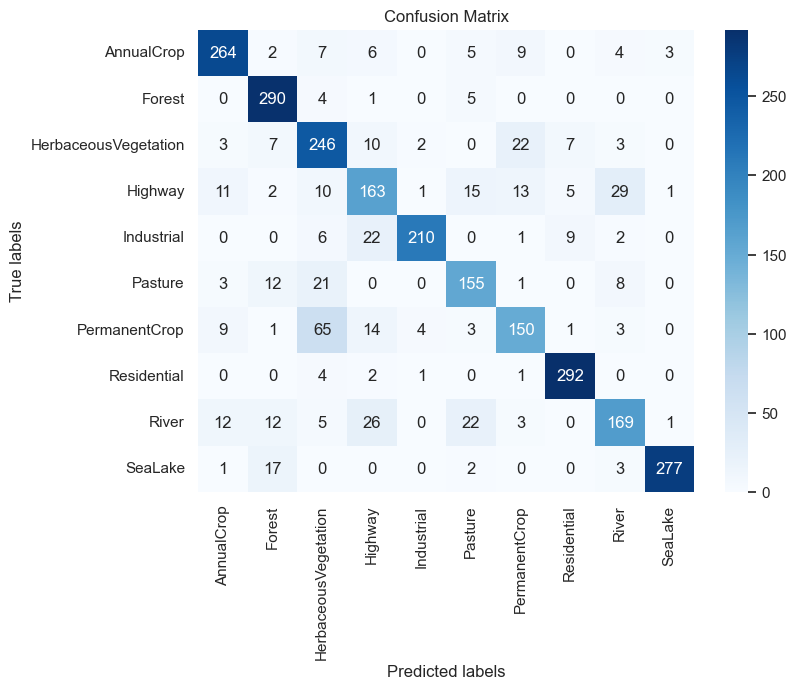

Classification Report: 
                       precision    recall  f1-score   support

          AnnualCrop       0.87      0.88      0.88       300
              Forest       0.85      0.97      0.90       300
HerbaceousVegetation       0.67      0.82      0.74       300
             Highway       0.67      0.65      0.66       250
          Industrial       0.96      0.84      0.90       250
             Pasture       0.75      0.78      0.76       200
       PermanentCrop       0.75      0.60      0.67       250
         Residential       0.93      0.97      0.95       300
               River       0.76      0.68      0.72       250
             SeaLake       0.98      0.92      0.95       300

            accuracy                           0.82      2700
           macro avg       0.82      0.81      0.81      2700
        weighted avg       0.82      0.82      0.82      2700



In [28]:
# Extract class labels from the data generators
class_labels = list(train_generator.class_indices.keys())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot confusion matrix heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: \n", classification_report(y_true, y_pred, target_names=class_labels))

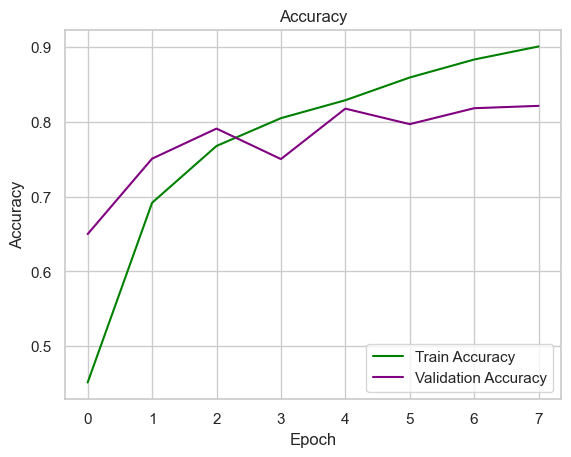

In [9]:
# Set colors
colors = ["green", "purple"]
# Set plot style
sns.set(style="whitegrid")
sns.set_palette(sns.color_palette(colors))
# Create the plot
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

## I read that inception expects images of size 299x299, so I defined these separate sets for those sizes

In [10]:
# Load CSV files
train_csv = pd.read_csv(r"C:\Users\Brenon\Desktop\archive\EuroSAT\train.csv")
test_csv = pd.read_csv(r"C:\Users\Brenon\Desktop\archive\EuroSAT\test.csv")
validation_csv = pd.read_csv(r"C:\Users\Brenon\Desktop\archive\EuroSAT\validation.csv")

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator_2 = train_datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=base_dir,
    x_col="Filename", 
    y_col="ClassName", 
    target_size=(299, 299),
    batch_size=8,
    class_mode='categorical')

test_generator_2 = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=base_dir,
    x_col="Filename",
    y_col="ClassName",
    target_size=(299, 299),
    batch_size=1,
    class_mode='categorical')

validation_generator_2 = validation_datagen.flow_from_dataframe(
    dataframe=validation_csv,
    directory=base_dir,
    x_col="Filename",
    y_col="ClassName",
    target_size=(299, 299),
    batch_size=8,
    class_mode='categorical')

Found 18900 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.


In [11]:
import numpy as np
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

# Load the pre-traine inception model 
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Time the model - begin
start_time_Inception = time.time()

# get CPU usage start
cpu_usage_start_Inception = psutil.cpu_percent(interval=None)

# Train the model
history = model.fit(train_generator_2,
                    epochs=30,
                    validation_data=validation_generator_2,
                    callbacks=[early_stopping_2])

# get CPU usage end
cpu_usage_end_Inception = psutil.cpu_percent(interval=None)

# Time the model - end
end_time_Inception = time.time()

# Evaluate the model
loss, accuracy = model.evaluate(test_generator_2)
print("Test Accuracy:", accuracy)
print("CPU usage:", cpu_usage_end_Inception-cpu_usage_start_Inception, "%")
print("CNN model elapsed training time:", end_time_Inception-start_time_Inception, "seconds")

Epoch 1/30


c:\Users\Brenon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2363/2363 ━━━━━━━━━━━━━━━━━━━━ 640s 268ms/step - accuracy: 0.8261 - loss: 0.5417 - val_accuracy: 0.8869 - val_loss: 0.3220
Epoch 2/30
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 635s 269ms/step - accuracy: 0.9209 - loss: 0.2312 - val_accuracy: 0.9048 - val_loss: 0.2771
Epoch 3/30
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 639s 271ms/step - accuracy: 0.9341 - loss: 0.1871 - val_accuracy: 0.9159 - val_loss: 0.2688
Epoch 4/30
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 666s 282ms/step - accuracy: 0.9425 - loss: 0.1594 - val_accuracy: 0.9193 - val_loss: 0.2662
Epoch 5/30
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 670s 283ms/step - accuracy: 0.9518 - loss: 0.1363 - val_accuracy: 0.9304 - val_loss: 0.2165
Epoch 6/30
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 630s 267ms/step - accuracy: 0.9600 - loss: 0.1137 - val_accuracy: 0.9344 - val_loss: 0.2150
Epoch 7/30
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 631s 267ms/step - accuracy: 0.9691 - loss: 0.0928 - val_accuracy: 0.9204 - val_loss: 0.2666
Epoch 8/30
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 644s 272ms/step - accuracy: 0.9

In [16]:
y_true_2 = []
y_probab_2 = []
for i in range(test_generator_2.samples // test_generator_2.batch_size):
    batch_data, batch_labels = next(test_generator_2)
    y_true_2.extend(np.argmax(batch_labels, axis=-1))
    y_probab_2.append(model.predict_on_batch(batch_data))

# Flatten the list of predictions
y_probab_2 = np.concatenate(y_probab_2)

# Create predicted classes
y_pred_2 = np.argmax(y_probab_2, axis=-1)

# Create confusion matrix
cm = confusion_matrix(y_true_2, y_pred_2)
print("Classification Report: \n", classification_report(y_true_2, y_pred_2))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       302
           1       0.95      0.98      0.97       292
           2       0.91      0.91      0.91       290
           3       0.88      0.87      0.88       251
           4       0.91      0.99      0.95       240
           5       0.86      0.94      0.90       203
           6       0.97      0.86      0.92       259
           7       0.96      0.97      0.97       311
           8       0.94      0.87      0.90       257
           9       0.99      0.99      0.99       295

    accuracy                           0.94      2700
   macro avg       0.94      0.94      0.94      2700
weighted avg       0.94      0.94      0.94      2700



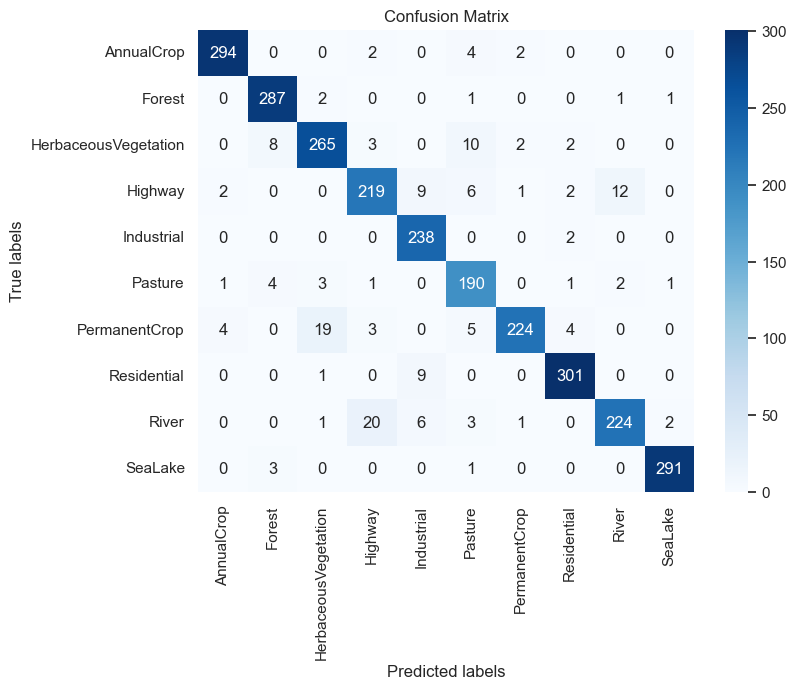

Classification Report: 
                       precision    recall  f1-score   support

          AnnualCrop       0.98      0.97      0.98       302
              Forest       0.95      0.98      0.97       292
HerbaceousVegetation       0.91      0.91      0.91       290
             Highway       0.88      0.87      0.88       251
          Industrial       0.91      0.99      0.95       240
             Pasture       0.86      0.94      0.90       203
       PermanentCrop       0.97      0.86      0.92       259
         Residential       0.96      0.97      0.97       311
               River       0.94      0.87      0.90       257
             SeaLake       0.99      0.99      0.99       295

            accuracy                           0.94      2700
           macro avg       0.94      0.94      0.94      2700
        weighted avg       0.94      0.94      0.94      2700



In [19]:
# Extract class labels from the data generators
class_labels = list(train_generator_2.class_indices.keys())

# Calculate confusion matrix
cm_2 = confusion_matrix(y_true_2, y_pred_2)

# Convert confusion matrix to DataFrame
cm_df_2 = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot confusion matrix heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: \n", classification_report(y_true_2, y_pred_2, target_names=class_labels))

## Poor Performing Models

In [25]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter
from sklearn.metrics import roc_curve, roc_auc_score

In [26]:
r"C:\Users\Brenon\Desktop\archive\EuroSAT"

base_dir = r"C:\Users\Brenon\Desktop\archive\EuroSAT"
# Get a list of class labels (subdirectories in the main directory)
class_labels = [label for label in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, label))]

# Create a dictionary to store the count of images for each class
class_counts = {}

# Loop through each class and count the number of images
for label in class_labels:
    class_path = os.path.join(base_dir, label)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[label] = num_images

for label, count in class_counts.items():
    print(f"Class '{label}' has {count} images.")

Class 'AnnualCrop' has 3000 images.
Class 'Forest' has 3000 images.
Class 'HerbaceousVegetation' has 3000 images.
Class 'Highway' has 2500 images.
Class 'Industrial' has 2500 images.
Class 'Pasture' has 2000 images.
Class 'PermanentCrop' has 2500 images.
Class 'Residential' has 3000 images.
Class 'River' has 2500 images.
Class 'SeaLake' has 3000 images.
Class 'test' has 0 images.
Class 'train' has 0 images.
Class 'validation' has 0 images.


In [27]:
# Define paths and initialize variables
data_dir = r"C:\Users\Brenon\Desktop\archive\EuroSAT"
labels = []
images = []

# Read data and apply basic preprocessing (adjust as needed)
for subdir in tqdm(os.listdir(data_dir), desc="Reading Images"):
    label = subdir
    for image_path in glob(f"{data_dir}/{subdir}/*.jpg"):
        # Read image and resize if needed
        img = cv2.imread(image_path)
        img = cv2.resize(img, (64, 64))  # Example resize, adjust as necessary
        images.append(img.flatten())  # Flatten for simplicity, adjust preprocessing
        labels.append(label)

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
print(f"Number of observations read: {len(images)}")

Reading Images: 100%|██████████| 17/17 [00:05<00:00,  3.30it/s]

Number of observations read: 27000


In [28]:
def get_cpu_usage():
    return psutil.cpu_percent

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2)

from sklearn.preprocessing import MinMaxScaler

# Feature Scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# get CPU usage start
cpu_usage_start_SVC = psutil.cpu_percent(interval=None)

# Build and train model
model = SVC(kernel='rbf')  # Example model, adjust parameters and explore other options
model.fit(X_train, y_train)

# get CPU usage end
cpu_usage_end_SVC = psutil.cpu_percent(interval=None)

# Predict on test set
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = np.mean(predictions == y_test)
print("Prediction accuracy:", accuracy)
print("CPU usage:", cpu_usage_end_SVC-cpu_usage_start_SVC, "%")

Accuracy: 0.3382222222222222
CPU usage: 1.5 %


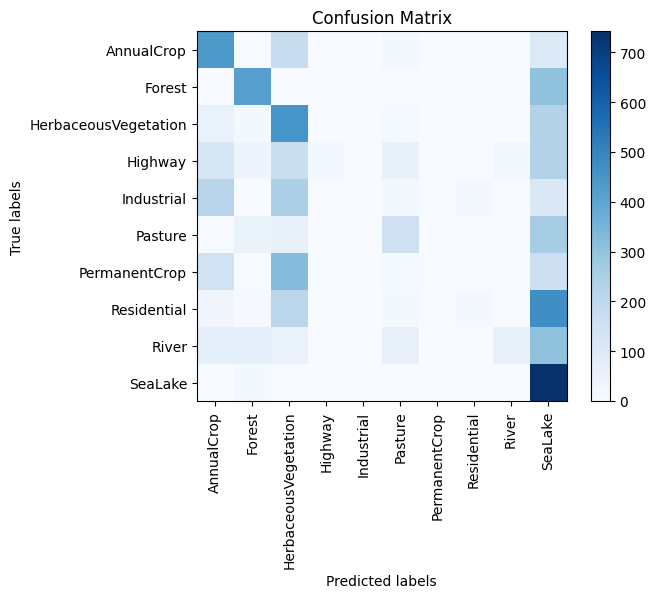

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.25)  # Adjust test size as needed

# Create a KNN classifier (experiment with different k values)
knn = KNeighborsClassifier(n_neighbors=10)

# get CPU usage start
cpu_usage_start_KNN = psutil.cpu_percent()

# Train the model on the training set
knn.fit(X_train, y_train)

# get CPU usage end
cpu_usage_end_KNN = psutil.cpu_percent()

# Make predictions on the testing set
y_pred = knn.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("CPU usage:", cpu_usage_end_KNN-cpu_usage_start_KNN, "%")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 
               'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Random Forest Classification

In [33]:
# Split data into training and testing sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(images, labels_encoded, test_size=0.25)  # Adjust test size as needed

# Create a Random Forest classifier (experiment with different parameters)
rf = RandomForestClassifier(n_estimators=100, max_depth=5)  # Adjust parameters as needed

# get CPU usage start
cpu_usage_start_RF = psutil.cpu_percent()

# Train the model on the training set
rf.fit(X_train_2, y_train_2)

# get CPU usage end
cpu_usage_end_RF = psutil.cpu_percent()

# Make predictions on the testing set
y_pred_2 = rf.predict(X_test_2)

# Evaluate model performance
accuracy_2 = accuracy_score(y_test_2, y_pred_2)
print("Accuracy:", accuracy_2)
print("CPU usage:", cpu_usage_end_RF-cpu_usage_start_RF, "%")

Accuracy: 0.49066666666666664
CPU usage: 8.799999999999999 %


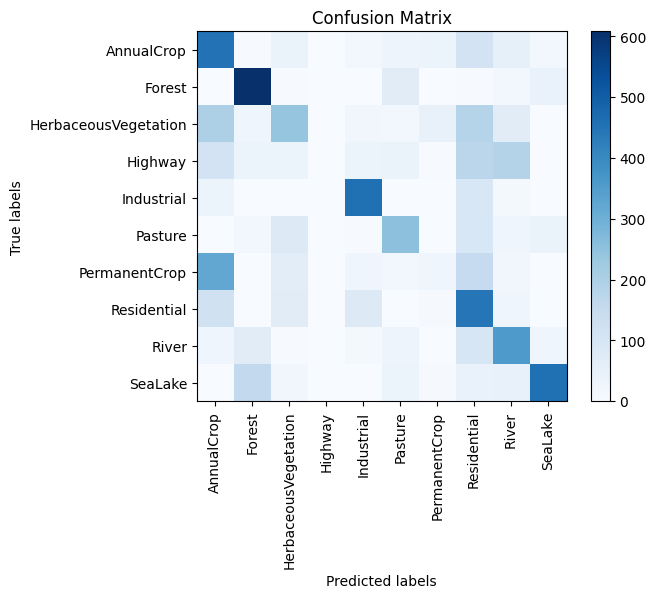

In [16]:
# Create a confusion matrix
cm_2 = confusion_matrix(y_test_2, y_pred_2)

class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 
               'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Plot the confusion matrix
plt.imshow(cm_2, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## XGBoost

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Split data into training and testing sets
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(images, labels_encoded, test_size=0.25, random_state=42)  # Adjust test size as needed

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier()

# get CPU usage start
cpu_usage_start_XGB = psutil.cpu_percent()

# Train the model on the training set
xgb_model.fit(X_train_3, y_train_3)

# get CPU usage end
cpu_usage_end_XGB = psutil.cpu_percent()

# Make predictions on the testing set
y_pred_3 = xgb_model.predict(X_test_3)

# Evaluate model performance
accuracy_3 = accuracy_score(y_test_3, y_pred_3)
print("Accuracy:", accuracy_3)
print("CPU usage:", cpu_usage_end_XGB-cpu_usage_start_XGB, "%")

Accuracy: 0.7413333333333333
CPU usage: 52.99999999999999 %


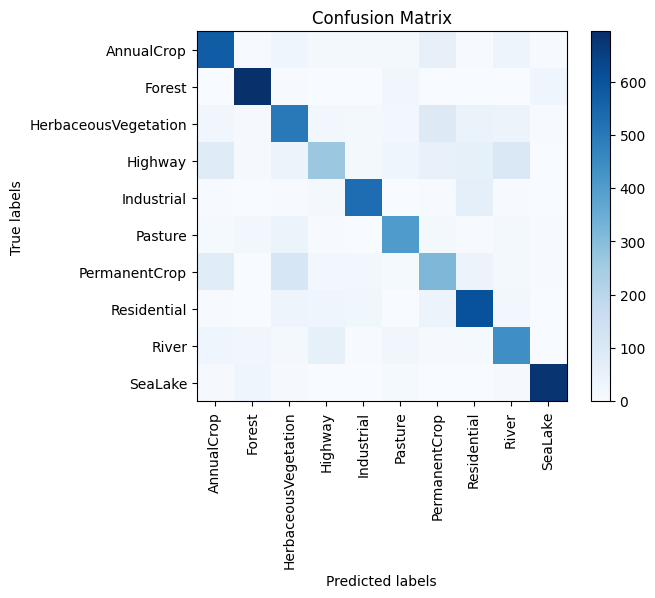

In [38]:
# Create a confusion matrix
cm_3 = confusion_matrix(y_test_3, y_pred_3)

class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 
               'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Plot the confusion matrix
plt.imshow(cm_3, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

### SVM Modeling

This block is completely commented out because the script will run for around 32 hours. We opted to not correct the graphs for it during the project, and instead didn't use the graphs, merely the information from the last time we ran the model. When we went back in to fix the graphs, and to get the descriptive statistics for the other models it would be time prohibitive to run this model again. 

In [ ]:
# Train-test split-

#X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2)

#from sklearn.preprocessing import MinMaxScaler

# Feature Scaling-

#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Build and train model-

#model = SVC(kernel='rbf')  # Example model, adjust parameters and explore other options
#model.fit(X_train, y_train)

# Predict on test set-

#predictions = model.predict(X_test)

# Calculate accuracy-

#accuracy = np.mean(predictions == y_test)
#print("Prediction accuracy:", accuracy)


In [ ]:
# Generate confusion matrix, this is different than the other matrices-

#cm = confusion_matrix(y_test, predictions)

# Normalize confusion matrix-

#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix-

#plt.imshow(cm_normalized, cmap='Blues')
#plt.colorbar()
#tick_marks = np.arange(len(le.classes_))
#plt.xticks(tick_marks, le.classes_, rotation=45)
#plt.yticks(tick_marks, le.classes_)
#plt.xlabel("Predicted Label")
#plt.ylabel("True Label")
#plt.title("Confusion Matrix")
#plt.show()